In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler,normalize
import scipy
import cartopy.crs as ccrs
import cartopy
from torchsampler import ImbalancedDatasetSampler

In [2]:
source = "../data_source/present_data.csv"
source2 = "../data_source/present_data_all.csv"

In [3]:
dataf = pd.read_csv(source)
dataf2 = pd.read_csv(source2)
f1 = dataf.dropna()
f2 = dataf2.dropna()

In [4]:
f3 = f2[~f2.isin(f1)].dropna()

In [5]:
f3.to_csv('../data_source/test.csv')

In [6]:
f2[f2['veg']==1]

,Unnamed: 0,latitude,longitude,t_winter,t_spring,t_summer,t_fall,p_winter,p_spring,p_summer,p_fall,carb,veg
0,0,32.5625,243.0625,13.209499,16.019327,21.191208,18.987041,1.781894,0.927823,0.079056,0.425362,1.498861,1.0
1,1,32.5625,243.1875,11.126074,14.355422,20.732061,17.534286,2.167904,1.174322,0.117344,0.646820,2.763761,1.0
2,2,32.6875,243.0625,13.274010,16.141298,21.413210,19.143139,1.801917,0.915378,0.073457,0.446339,1.848117,1.0
3,3,32.6875,243.1875,12.192781,15.664566,22.704735,19.012733,2.169224,1.197534,0.113007,0.653634,5.562317,1.0
4,4,32.6875,243.3125,9.981687,13.987834,22.163626,17.377697,2.418175,1.320502,0.172150,0.723509,6.725700,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,2252,41.9375,239.1875,-0.480211,6.703880,17.053543,8.508671,1.954956,1.315168,0.745315,0.796276,11.961967,1.0
2253,2253,41.9375,239.3125,-0.995038,6.437559,16.856579,8.233111,2.065043,1.487056,0.812014,0.872478,15.995222,1.0
2254,2254,41.9375,239.4375,-0.811066,6.869605,17.391779,8.611520,2.017557,1.454433,0.824363,0.879763,18.763595,1.0
2255,2255,41.9375,239.6875,-0.259012,7.747982,18.278526,9.367978,3.138676,2.110202,0.828480,1.350737,28.116061,1.0


In [7]:
f_dataf = dataf.dropna()
f_dataf.shape
data_np = f_dataf.to_numpy(dtype="float32")

In [50]:
pars = list(f_dataf.columns)
print(pars)

['Unnamed: 0', 'latitude', 'longitude', 't_winter', 't_spring', 't_summer', 't_fall', 'p_winter', 'p_spring', 'p_summer', 'p_fall', 'carb', 'veg']


(1912, 2)
Clustering completed after 13 iterations
(1912, 2)


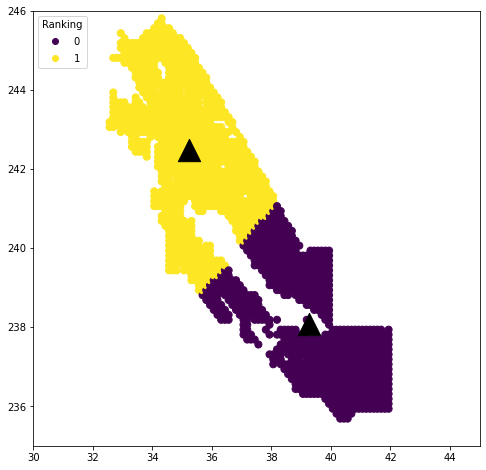

(1912,) (1912,)
200.0
model_0 select 200 sample


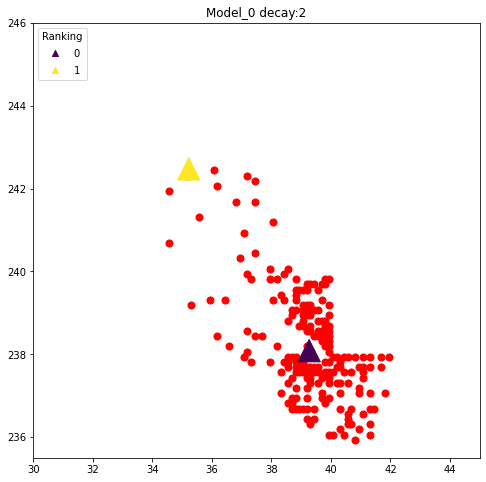

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

class ClusterGenerator:
    def __init__(self, moduelNum, dataSource="../data_source/present_data.csv"):
        self.num = moduelNum
        self.source = dataSource
        self.classifications = None
        self.centers = None
        self.oriData = None
        self.decay = None

        self.meanShiftData = None
        self.uniformData = None

    def dataMap(self):
        None

    def loadData(self):
        dataf = pd.read_csv(self.source)
        f_dataf = dataf.dropna()
        self.oriData = f_dataf

        # Make a copy of outPut data 
        self.meanShiftData = self.oriData.copy()
        self.uniformData = self.oriData.copy()

        self.data_np = f_dataf.to_numpy(dtype="float32")        
        self.location_data = self.data_np[:,1:3]
        print(self.location_data.shape)
        return None

    def showCluster(self):
        plt.figure(figsize=(8, 8))
        scatter1 = plt.scatter(x=self.location_data[:, 0], y=self.location_data[:, 1], s=50, c=self.classifications)
        print(self.location_data.shape)
        plt.scatter(x=self.centers[:, 0], y=self.centers[:, 1], s=500, c='k', marker='^')
        plt.legend(*scatter1.legend_elements(),
                    loc="upper left", title="Ranking")

        plt.xlim([30, 45])
        plt.ylim([235,246])
        plt.show()
        
    def showSingle(self,indx):
        plt.figure(figsize=(8, 8))
        la,lo = self.centers[indx]
        points = self.uniformData[self.uniformData["model_{}".format(indx)]==1].to_numpy(dtype="float32")
        plt.scatter(x=points[:, 1], y=points[:, 2], s=50,c=['red'])
        scatter2 =plt.scatter(x=self.centers[:, 0], y=self.centers[:, 1], s=500, c=range(len(self.centers)), marker='^',)
        plt.title("Model_{} decay:{}".format(indx,self.decay))
        plt.legend(*scatter2.legend_elements(),
                    loc="upper left", title="Ranking")

        plt.xlim([30, 45])
        plt.ylim([235.5,246])
        plt.show()
    
    def kmeans(self, normalize=False, limit=200):

        """Basic k-means clustering algorithm.
        """
        # optionally normalize the data. k-means will perform poorly or strangely if the dimensions
        # don't have the same ranges.

        data = self.location_data
        k = self.num

        if normalize:
            stats = (data.mean(axis=0), data.std(axis=0))
            data = (data - stats[0]) / stats[1]
        
        # pick the first k points to be the centers. this also ensures that each group has at least
        # one point.
        centers = data[:k]

        for i in range(limit):
            # core of clustering algorithm...
            # first, use broadcasting to calculate the distance from each point to each center, then
            # classify based on the minimum distance.
            classifications = np.argmin(((data[:, :, None] - centers.T[None, :, :])**2).sum(axis=1), axis=1)
            # next, calculate the new centers for each cluster.
            new_centers = np.array([data[classifications == j, :].mean(axis=0) for j in range(k)])

            # if the centers aren't moving anymore it is time to stop.
            if (new_centers == centers).all():
                break
            else:
                centers = new_centers
        else:
            # this will not execute if the for loop exits on a break.
            raise RuntimeError(f"Clustering algorithm did not complete within {limit} iterations")
                
        # if data was normalized, the cluster group centers are no longer scaled the same way the original
        # data is scaled.
        if normalize:
            centers = centers * stats[1] + stats[0]

        print(f"Clustering completed after {i} iterations")
        
        
        self.classifications = classifications
        self.centers = centers
        self.meanShiftData['cluster'] = classifications

    def randomSample(self, decay=2,size=200):
        self.decay = decay
        for indx in range(len(self.centers)):
            la, lo = self.centers[indx]
            distence = np.sqrt((self.data_np[:,1]-la)**2+(self.data_np[:,2]-lo)**2)
            probability = 1./(distence**decay)
            probability = probability/sum(probability)
            # print(sum(probability))
            # probability1 = normalize((1./(distence*decay)).reshape(1,-1))
            # probability2 = normalize((1./(distence)).reshape(1,-1))
            # print(probability1,probability2)
            # probability = np.exp(-distence*decay)
            # probability = scipy.stats.norm.cdf(1./(distence*decay)) 
            # print(min(probability),max(probability))
            # model_selection = np.random.binomial(1, p=probability.reshape(-1))
            # print(range(self.data_np.shape[0]))
            print(np.arange(self.data_np.shape[0]).shape,probability.shape)
            model_selection = np.random.choice(np.arange(self.data_np.shape[0]),size,replace=False,p=probability)

            model_mask = np.zeros(probability.shape[0])
            model_mask[model_selection] = 1
            print(sum(model_mask))
            self.uniformData['model_{}'.format(indx)] = model_mask
            print("model_{} select {} sample".format(indx,size))
            break
    
cg = ClusterGenerator(2)
cg.loadData()
cg.kmeans()
cg.showCluster()
cg.randomSample()
cg.showSingle(0)


# %matplotlib inline



In [136]:
print (min(data_np[:,1]),max(data_np[:,1]),min(data_np[:,2]),max(data_np[:,2]))

32.5625 41.9375 235.6875 245.8125


In [20]:
centers = cg.centers

for indx in range(len(centers)):
    la, lo = centers[indx]
    distence = np.sqrt((data_np[:,1]-la)**2+(data_np[:,2]-lo)**2)
    break

In [37]:
distence

array([3.368438 , 3.45522  , 3.2784455, ..., 7.569781 , 7.5199738,
       7.4719257], dtype=float32)

In [22]:
data_np[:3,:3]

array([[  0.    ,  32.5625, 243.0625],
       [  1.    ,  32.5625, 243.1875],
       [  2.    ,  32.6875, 243.0625]], dtype=float32)

In [35]:
ah = 0.02
ta = np.array([3, 5, 8])
p1 = normalize((1./ta).reshape(1,-1))
p2 = normalize((1./(ta**ah)).reshape(1,-1))
print(p1,p2)

[[0.81632653 0.48979592 0.30612245]] [[0.58308287 0.57715612 0.57175623]]


In [25]:
normalize(distence.reshape(1,-1))

array([[0.01872189, 0.01920423, 0.01822171, ..., 0.04207309, 0.04179627,
        0.04152921]], dtype=float32)

In [44]:
from sklearn.preprocessing import StandardScaler
from torch import nn

class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

  def __len__(self):
    return self.length

class Net(nn.Module):

  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    # self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(32,1)
    # self.y_class = nn.Linear(32,1)

  def forward(self,x):
    x = torch.relu(self.fc1(x))
    # x = torch.relu(self.fc2(x))
    # x = torch.sigmoid(self.fc3(x))
    x = self.fc3(x)
    x = torch.sigmoid(x)
   
    return x

SPLIT_THRES = 0.8

data_np = cg.clusterData.to_numpy(dtype="float32")
print(data_np.shape)
net_list = []
for idx in range(cg.centers.shape[0]):
    cls_data = data_np[data_np[:,-1]==idx] #Filtered by cluster
    np.random.shuffle(cls_data)
    x_full = cls_data[:, 3:-3]
    y_full = cls_data[:, -2]
    

    split_indx = int(x_full.shape[0]*SPLIT_THRES)
    x_train = x_full[:split_indx]
    y_train = y_full[:split_indx]
    x_val = x_full[split_indx:]
    y_val = y_full[split_indx:]

    print(x_train.shape,x_val.shape)

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_val = sc.transform(x_val)
    print(type(x_train),type(x_val))

    # train_size = int(0.8 * len(full_dataset))
    # test_size = len(full_dataset) - train_size
    # train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_dataset = dataset(x_train, y_train)
    val_dataset = dataset(x_val, y_val)

    trainloader = DataLoader(train_dataset,batch_size=16,shuffle=True)
    valloader = DataLoader(val_dataset,batch_size=16,shuffle=False)
    print(len(train_dataset))


    net = Net(x_full.shape[1])
    optimizer = torch.optim.SGD(net.parameters(), lr=0.005)
    class_loss_func = torch.nn.BCELoss()  # the target label is NOT an one-hotted

    

    # print(net)
    train_losses = []
    train_accur = []
    val_losses = []
    val_accur = []
    for i in range(200):
        for j,(x,y) in enumerate(trainloader):
            #calculate output
            output = net(x)
        
            #calculate loss
            train_loss = class_loss_func(output,y.reshape(-1,1))
        
            # loss = reg_loss_func(output,y )
        
            #class accuracy
            
            predicted = net(torch.tensor(x_train, dtype=torch.float32))
            train_acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()

            #backprop


        for j_v,(x_v,y_v) in enumerate(valloader):

          val_output = net(x_v)
      
          #calculate loss
          val_loss = class_loss_func(val_output,y_v.reshape(-1,1))

          #class accuracy
          
          predicted = net(torch.tensor(x_val, dtype=torch.float32))
          val_acc = (predicted.reshape(-1).detach().numpy().round() == y_val).mean()

        if i%20 == 0:
            train_losses.append(train_loss.data)
            train_accur.append(train_acc)
            val_losses.append(val_loss.data)
            val_accur.append(val_acc)
            # print("Net: {} epoch: {:<5} train_loss:{:5f} train_accuracy:{:5f}".format(idx, i,train_loss,train_acc))
                # val_losses.append(val_loss.data)
                # val_accur.append(val_acc)
            print("epoch {:<5} train_loss:{:.5f} val_loss: {:.5f} train_accuracy:{:.5f} val_accuracy: {:.5f}".format(i,train_loss,val_loss,train_acc,val_acc))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    net_list.append([net,[train_losses,train_accur]])


(1912, 14)
(158, 8) (40, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
158
epoch 0     train_loss:0.71632 val_loss: 0.77135 train_accuracy:0.22152 val_accuracy: 0.20000
epoch 20    train_loss:0.65032 val_loss: 0.69336 train_accuracy:0.49367 val_accuracy: 0.42500
epoch 40    train_loss:0.61679 val_loss: 0.62356 train_accuracy:0.80380 val_accuracy: 0.85000
epoch 60    train_loss:0.53713 val_loss: 0.56243 train_accuracy:0.94937 val_accuracy: 0.97500
epoch 80    train_loss:0.40176 val_loss: 0.50752 train_accuracy:0.94937 val_accuracy: 0.97500
epoch 100   train_loss:0.26418 val_loss: 0.46305 train_accuracy:0.94937 val_accuracy: 0.97500
epoch 120   train_loss:0.28718 val_loss: 0.42386 train_accuracy:0.94937 val_accuracy: 0.97500
epoch 140   train_loss:0.16300 val_loss: 0.38743 train_accuracy:0.94937 val_accuracy: 0.97500
epoch 160   train_loss:0.37562 val_loss: 0.35497 train_accuracy:0.94937 val_accuracy: 0.97500
epoch 180   train_loss:0.20233 val_loss: 0.32431 train_accuracy:0.94937 va

In [8]:

data_np = f_dataf.to_numpy(dtype="float32")
x_train = data_np[:1600,3:11]
x_val = data_np[1600:,3:11]

y_train = data_np[:1600,12]
y_val= data_np[1600:,12]

## Normalize the input data
# sc = StandardScaler()
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
# y_train = (y_train-min(y_train))/(max(y_train)-min(y_train)) 

x_val = sc.fit_transform(x_val)
# y_val = (y_val-min(y_val))/(max(y_val)-min(y_val))
y_train -= 1
y_val -= 1

print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

  def __len__(self):
    return self.length

trainset = dataset(x_train,y_train)
valset = dataset(x_val,y_val)
#DataLoader
trainloader = DataLoader(trainset,batch_size=16,shuffle=True)
valloader = DataLoader(valset,batch_size=16,shuffle=False)





(1600, 8) (1600,)
(312, 8) (312,)


In [9]:
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()


class Net(nn.Module):

  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    # self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(32,1)
    # self.y_class = nn.Linear(32,1)

  def forward(self,x):
    x = torch.relu(self.fc1(x))
    # x = torch.relu(self.fc2(x))
    # x = torch.sigmoid(self.fc3(x))
    x = self.fc3(x)
    x = torch.sigmoid(x)
   
    return x


net = Net(8)     # define the network
# if torch.cuda.is_available():
#     print("using Gpu")
#     net = net.cuda()
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
reg_loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
class_loss_func = torch.nn.BCELoss()  # the target label is NOT an one-hotted



Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [10]:
train_losses = []
train_accur = []
val_losses = []
val_accur = []

for i in range(100):
  for j,(x,y) in enumerate(trainloader):
    
    #calculate output
    output = net(x)
 
    #calculate loss
    train_loss = class_loss_func(output,y.reshape(-1,1))
 
    # loss = reg_loss_func(output,y )
 
    #class accuracy
    
    predicted = net(torch.tensor(x_train, dtype=torch.float32))
    train_acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()

    #backprop
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

  for j,(x,y) in enumerate(valloader):

    val_output = net(x)
 
    #calculate loss
    val_loss = class_loss_func(val_output,y.reshape(-1,1))

    #class accuracy
    
    predicted = net(torch.tensor(x_train, dtype=torch.float32))
    val_acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()


  if i%10 == 0:
    train_losses.append(train_loss.data)
    train_accur.append(train_acc)
    val_losses.append(val_loss.data)
    val_accur.append(val_acc)
    print("epoch {:<5} train_loss:{:5f} val_loss: {:5f} train_accuracy:{:5f} val_accuracy: {:5f}".format(i,train_loss,val_loss,train_acc,val_acc))

epoch 0     train_loss:0.701973 val_loss: 0.692498 train_accuracy:0.106875 val_accuracy: 0.105625
epoch 10    train_loss:0.455892 val_loss: 0.726287 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 20    train_loss:0.693690 val_loss: 0.784467 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 30    train_loss:0.407863 val_loss: 0.825267 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 40    train_loss:0.341808 val_loss: 0.847235 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 50    train_loss:0.522714 val_loss: 0.857197 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 60    train_loss:0.264194 val_loss: 0.860537 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 70    train_loss:0.646016 val_loss: 0.860665 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 80    train_loss:0.894377 val_loss: 0.858939 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 90    train_loss:0.215544 val_loss: 0.856662 train_accuracy:0.821250 val_accuracy: 0.821250


In [12]:
predicted.reshape(-1).detach().numpy().round().sum()

0.0

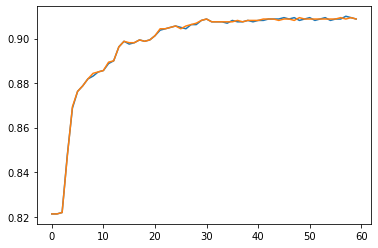

In [72]:

plt.plot(train_accur)
plt.plot(val_accur)
plt.show()

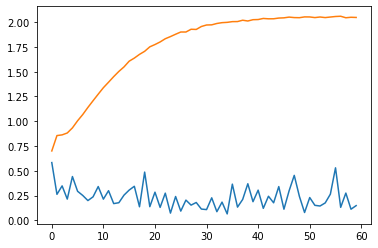

In [73]:
plt.plot(train_losses)
plt.plot(val_losses)

In [63]:

for i in range(len(net_list)):
    train_losses = net_list[i][1][0]
    plt.plot(train_losses,label="Net:{},data#:{}".format(i,data_np[data_np[:,-1]==i].shape[0]))
    # plt.plot(val_losses,label='val')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs * 10')
    plt.ylabel('loss')
    plt.legend()

NameError: name 'net_list' is not defined

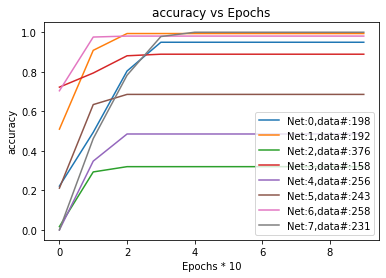

In [46]:
for i in range(len(net_list)):
    train_accur = net_list[i][1][1]
    plt.plot(train_accur,label="Net:{},data#:{}".format(i,data_np[data_np[:,-1]==i].shape[0]))
    # plt.plot(val_losses,label='val')
    plt.title('accuracy vs Epochs')
    plt.xlabel('Epochs * 10')
    plt.ylabel('accuracy')
    plt.legend()

IndexError: index 1 is out of bounds for dimension 1 with size 1

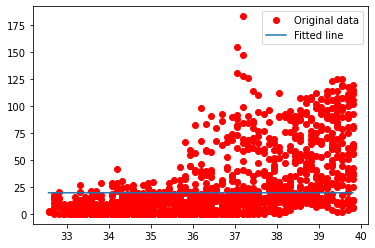

In [30]:
predicted = net(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train[:,0], y_train, 'ro', label='Original data')
plt.plot(x_train[:,0], predicted, label='Fitted line')
plt.legend()
plt.show()

(1600, 8) (1600, 1) (1600, 1)
Net(
  (hidden): Linear(in_features=8, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (predict_class): Linear(in_features=32, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predict_reg): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
x:torch.Size([1600, 8]) y1:torch.Size([1600, 1]) y2:torch.Size([1600, 1])y1_train:(1600, 1)y2_train(1600, 1)
tensor(0.7489, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.4648, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1769, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-0.1678, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-0.5984, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-1.1760, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-2.0008, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-3

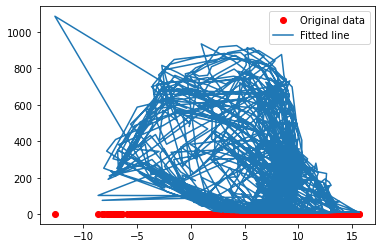

(-15.0, 15.0)

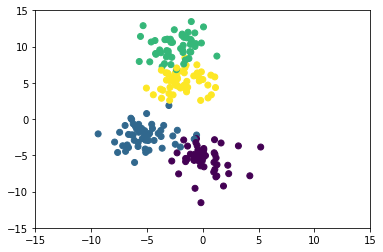

In [148]:
# import statements
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)

In [18]:
cg.clusterData[cg.clusterData['cluster'] == 0]

,Unnamed: 0,latitude,longitude,t_winter,t_spring,t_summer,t_fall,p_winter,p_spring,p_summer,p_fall,carb,veg,cluster
265,265,34.3125,240.6875,12.673417,15.279175,20.107550,17.995707,2.738192,0.956680,0.038420,0.708766,10.207090,1.0,0
266,266,34.3125,240.8125,12.915713,15.333584,19.770353,17.944431,2.632629,0.929270,0.039727,0.703246,6.834608,1.0,0
306,306,34.4375,240.5625,9.984474,12.831476,17.848717,15.537080,4.090013,1.445341,0.045205,0.981243,24.921393,2.0,0
307,307,34.4375,240.6875,11.274170,14.624917,20.577286,17.466093,3.240951,1.167551,0.044709,0.811583,18.621461,1.0,0
308,308,34.4375,240.8125,10.430933,13.923525,20.111055,16.794477,3.443468,1.199076,0.044417,0.892705,17.383121,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,1088,36.9375,239.0625,8.681682,16.117730,24.607367,18.001232,1.276815,0.508271,0.034925,0.438944,0.989707,1.0,0
1089,1089,36.9375,240.1875,9.623520,16.959682,26.844252,19.182852,1.737739,0.933559,0.068731,0.590391,9.173672,1.0,0
1090,1090,36.9375,240.3125,9.452579,16.558691,26.605762,19.035355,1.954302,1.006050,0.066783,0.638782,11.409437,1.0,0
1091,1091,36.9375,240.4375,9.719103,16.590399,26.925142,19.254158,2.379324,1.172087,0.087602,0.728828,11.528240,1.0,0


In [83]:
test_source = "../data_source/test_data.csv"


In [84]:
test_df = pd.read_csv(test_source).to_numpy(dtype="float32")
x_full = test_df[:,3:11]
y_full = test_df[:,11:13]
y_cls = y_full[:,1]
y_reg = y_full[:,0]

In [85]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [89]:
pd2 = pd.read_csv('../temp/meanShiftData.csv')
pd1 = pd.read_csv('../data_source/present_data.csv')
pd3 = pd.read_csv('../temp/sampleData.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../temp/sampleData.csv'

In [87]:
pd1

,Unnamed: 0,Unnamed: 0.1,latitude,longitude,t_winter,t_spring,t_summer,t_fall,p_winter,p_spring,p_summer,p_fall,carb,veg,model_0
0,0,0,32.5625,243.0625,13.209499,16.019327,21.191208,18.987041,1.781894,0.927823,0.079056,0.425362,1.498861,1.0,1.0
1,1,1,32.5625,243.1875,11.126074,14.355422,20.732061,17.534286,2.167904,1.174322,0.117344,0.646820,2.763761,1.0,1.0
2,2,2,32.6875,243.0625,13.274010,16.141298,21.413210,19.143139,1.801917,0.915378,0.073457,0.446339,1.848117,1.0,1.0
3,3,3,32.6875,243.1875,12.192781,15.664566,22.704735,19.012733,2.169224,1.197534,0.113007,0.653634,5.562317,1.0,1.0
4,4,4,32.6875,243.3125,9.981687,13.987834,22.163626,17.377697,2.418175,1.320502,0.172150,0.723509,6.725700,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1907,2242,2242,41.9375,237.4375,2.324508,9.342533,19.433820,11.060002,3.026568,0.989328,0.449903,1.093923,22.685206,1.0,1.0
1908,2243,2243,41.9375,237.5625,3.219994,10.196562,20.260645,11.946576,2.297202,0.820435,0.452079,0.942086,10.326124,1.0,1.0
1909,2244,2244,41.9375,237.6875,1.430400,8.375308,18.383022,10.134927,2.848567,1.277118,0.556918,1.222243,30.629481,1.0,1.0
1910,2245,2245,41.9375,237.8125,-0.237994,6.859822,16.808168,8.492342,2.381254,1.033747,0.545428,0.877401,46.384072,2.0,1.0


In [88]:
pd2

,Unnamed: 0,latitude,longitude,t_winter,t_spring,t_summer,t_fall,p_winter,p_spring,p_summer,p_fall,carb,veg
0,0,32.5625,243.0625,13.209499,16.019327,21.191208,18.987041,1.781894,0.927823,0.079056,0.425362,1.498861,1.0
1,1,32.5625,243.1875,11.126074,14.355422,20.732061,17.534286,2.167904,1.174322,0.117344,0.646820,2.763761,1.0
2,2,32.6875,243.0625,13.274010,16.141298,21.413210,19.143139,1.801917,0.915378,0.073457,0.446339,1.848117,1.0
3,3,32.6875,243.1875,12.192781,15.664566,22.704735,19.012733,2.169224,1.197534,0.113007,0.653634,5.562317,1.0
4,4,32.6875,243.3125,9.981687,13.987834,22.163626,17.377697,2.418175,1.320502,0.172150,0.723509,6.725700,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,2253,41.9375,239.3125,-0.995038,6.437559,16.856579,8.233111,2.065043,1.487056,0.812014,0.872478,NaN,1.0
2254,2254,41.9375,239.4375,-0.811066,6.869605,17.391779,8.611520,2.017557,1.454433,0.824363,0.879763,NaN,1.0
2255,2255,41.9375,239.6875,-0.259012,7.747982,18.278526,9.367978,3.138676,2.110202,0.828480,1.350737,NaN,1.0
2256,2256,41.9375,239.8125,-2.894123,5.198651,15.535978,6.741703,4.000875,2.655108,0.830156,1.703561,NaN,2.0
